In [34]:
import json
import re
import os
import random
import fitz
import matplotlib.pyplot as plt

# Input and Output File Paths
input_file = "titles_and_abstracts.txt"  # Replace with the actual path to your .txt file
defcon_file = "blackhat/blackhat_transcripts.json"  # Replace with the actual path to your defcon file
capec_file = "cwe_capec_complete/capec.json"  # Replace with the actual path to your CAPEC file
cwe_file = "cwe_capec_complete/capec.json"  # Replace with the actual path to your CAPEC file
tectac = "cwe_capec_complete/mitre_attack_data.json"
pdf_folder = "pdfs"
masked_cve_file = "masked_descriptions.json"  # File containing masked CVE descriptions
output_file = "output.json"

# Initialize the JSON structure
data = {
    "positive labels": []
}

# Regular Expressions for Title and Abstract extraction
title_pattern = r"Title: (.*?)\n"
abstract_pattern = r"Abstract: (.*?)\n(?=Title:|\Z)"

def extract_data(text):
    """Extract titles and abstracts using regular expressions."""
    titles = re.findall(title_pattern, text, re.DOTALL)
    abstracts = re.findall(abstract_pattern, text, re.DOTALL)
    return titles, abstracts

def split_paragraphs_by_sentence(abstract):
    """Split an abstract into paragraphs where a dot is followed by an uppercase letter."""
    sentences = re.split(r"(?<=[\.])\s+(?=[A-Z])", abstract)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

def add_defcon_data(defcon_file):
    """Add data from the defcon file structured as JSON."""
    with open(defcon_file, "r", encoding="utf-8") as file:
        defcon_data = json.load(file)
        for key, paragraphs in defcon_data.items():
            for paragraph in paragraphs:
                data["positive labels"].append({
                    "type": "defcon",
                    "description": paragraph.strip(),
                    "embedding": "",
                    "word_count": len(paragraph.strip().split())
                })

def add_capec_data(capec_file):
    """Add data from the CAPEC file structured as JSON."""
    with open(capec_file, "r", encoding="utf-8") as file:
        capec_data = json.load(file)
        for node in capec_data.get("nodes", []):
            data["positive labels"].append({
                "type": "capec",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def add_cwe_data(cwe_file):
    """Add data from the CWE file structured as JSON."""
    with open(cwe_file, "r", encoding="utf-8") as file:
        cwe_data = json.load(file)
        for node in cwe_data.get("nodes", []):
            data["positive labels"].append({
                "type": "cwe",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def add_pdf_paragraphs(pdf_folder, min_chars=40):
    """Extract meaningful paragraphs from PDFs and add them to positive labels."""
    for filename in os.listdir(pdf_folder):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, filename)
            pdf_document = fitz.open(pdf_path)

            for page_num in range(len(pdf_document)):
                page = pdf_document[page_num]
                text_blocks = page.get_text("blocks")

                for block in text_blocks:
                    _, _, _, _, text, _, _ = block
                    if is_meaningful_paragraph(text, min_chars):
                        data["positive labels"].append({
                            "type": "pdf_paragraph",
                            "description": text.strip(),
                            "embedding": "",
                            "word_count": len(text.strip().split())
                        })

def add_tectac_data(tectac_file):
    """Add data from the MITRE ATT&CK file structured as JSON."""
    with open(tectac_file, "r", encoding="utf-8") as file:
        tectac_data = json.load(file)
        for node in tectac_data.get("nodes", []):
            data["positive labels"].append({
                "type": "tectac",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def is_meaningful_paragraph(paragraph, min_chars=40):
    """Check if a paragraph is meaningful based on minimum character length."""
    paragraph = paragraph.strip()
    return len(paragraph) >= min_chars

def add_masked_cve_data(masked_cve_file, sample_size=41399):
    """Add randomly sampled masked CVE descriptions."""
    with open(masked_cve_file, "r", encoding="utf-8") as file:
        masked_descriptions = json.load(file)
        sampled_descriptions = random.sample(masked_descriptions, min(sample_size, len(masked_descriptions)))
        for description in sampled_descriptions:
            data["positive labels"].append({
                "type": "masked_cve",
                "description": description,
                "embedding": "",
                "word_count": len(description.split())
            })

def plot_word_count_distribution(data):
    """Plot the distribution of word counts for descriptions."""
    word_counts = [entry["word_count"] for entry in data["positive labels"] if 1 <= entry["word_count"] <= 100]
    
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=range(1, 102), edgecolor="black", alpha=0.7)
    plt.title("Word Count Distribution of Descriptions (1-100 Words)")
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Descriptions")
    plt.xticks(range(0, 101, 5))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Read the input file
with open(input_file, "r", encoding="utf-8") as file:
    text = file.read()

# Extract titles and abstracts
titles, abstracts = extract_data(text)

# Populate the JSON structure with abstracts
for abstract in abstracts:
    paragraphs = split_paragraphs_by_sentence(abstract)
    for para in paragraphs:
        data["positive labels"].append({
            "type": "abstract",
            "description": para,
            "embedding": "",
            "word_count": len(para.split())
        })

# Add data from various sources
add_defcon_data(defcon_file)
add_capec_data(capec_file)
add_cwe_data(cwe_file)
add_tectac_data(tectac)
add_pdf_paragraphs(pdf_folder)
add_masked_cve_data(masked_cve_file)

# Write the data to a JSON file
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(data, file, indent=4)

print(f"JSON file has been created successfully: {output_file}")


JSON file has been created successfully: output.json


In [28]:
import json
import re
import os
import fitz
import matplotlib.pyplot as plt
# Input and Output File Paths
input_file = "titles_and_abstracts.txt"  # Replace with the actual path to your .txt file
defcon_file = "blackhat/blackhat_transcripts.json"  # Replace with the actual path to your defcon file
capec_file = "cwe_capec_complete/capec.json"  # Replace with the actual path to your CAPEC file
cwe_file = "cwe_capec_complete/capec.json"  # Replace with the actual path to your CAPEC file
tectac = "cwe_capec_complete/mitre_attack_data.json"
pdf_folder="pdfs"
output_file = "output.json"

# Initialize the JSON structure
data = {
    "positive labels": []
}

# Regular Expressions for Title and Abstract extraction
title_pattern = r"Title: (.*?)\n"
abstract_pattern = r"Abstract: (.*?)\n(?=Title:|\Z)"

def extract_data(text):
    """
    Extract titles and abstracts using regular expressions.
    """
    titles = re.findall(title_pattern, text, re.DOTALL)
    abstracts = re.findall(abstract_pattern, text, re.DOTALL)
    return titles, abstracts

def split_paragraphs_by_sentence(abstract):
    """
    Split an abstract into paragraphs where a dot is followed by an uppercase letter.
    """
    # Use regex to find sentence boundaries where a dot is followed by an uppercase letter
    sentences = re.split(r"(?<=[\.])\s+(?=[A-Z])", abstract)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

def add_defcon_data(defcon_file):
    """
    Add data from the defcon file structured as JSON.
    """
    with open(defcon_file, "r", encoding="utf-8") as file:
        defcon_data = json.load(file)
        for key, paragraphs in defcon_data.items():
            for paragraph in paragraphs:
                data["positive labels"].append({
                    "type": "defcon",
                    "description": paragraph.strip(),
                    "embedding": "",
                    "word_count": len(paragraph.strip().split())
                })

def add_capec_data(capec_file):
    """
    Add data from the CAPEC file structured as JSON.
    """
    with open(capec_file, "r", encoding="utf-8") as file:
        capec_data = json.load(file)
        for node in capec_data.get("nodes", []):
            data["positive labels"].append({
                "type": "capec",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def add_cwe_data(cwe_file):
    """
    Add data from the CAPEC file structured as JSON.
    """
    with open(cwe_file, "r", encoding="utf-8") as file:
        capec_data = json.load(file)
        for node in capec_data.get("nodes", []):
            data["positive labels"].append({
                "type": "cwe",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def is_meaningful_paragraph(paragraph, min_chars=40):
    """
    Check if a paragraph is meaningful based on minimum character length.
    """
    paragraph = paragraph.strip()
    return len(paragraph) >= min_chars

def add_pdf_paragraphs(pdf_folder, min_chars=40):
    """
    Extract meaningful paragraphs from PDFs and add them to positive labels.
    """
    for filename in os.listdir(pdf_folder):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, filename)
            pdf_document = fitz.open(pdf_path)

            for page_num in range(len(pdf_document)):
                page = pdf_document[page_num]
                text_blocks = page.get_text("blocks")

                for block in text_blocks:
                    _, _, _, _, text, _, _ = block
                    if is_meaningful_paragraph(text, min_chars):
                        data["positive labels"].append({
                            "type": "pdf_paragraph",
                            "description": text.strip(),
                            "embedding": "",
                            "word_count": len(text.strip().split())
                        })

def add_tectac_data(tectac):
    """
    Add data from the CAPEC file structured as JSON.
    """
    with open(tectac, "r", encoding="utf-8") as file:
        tectac_data = json.load(file)
        for node in tectac_data.get("nodes", []):
            data["positive labels"].append({
                "type": "tectac",
                "description": node["description"].strip(),
                "embedding": "",
                "word_count": len(node["description"].strip().split())
            })

def plot_word_count_distribution(data):
    """
    Plot the distribution of word counts for descriptions.
    """
    word_counts = [entry["word_count"] for entry in data["positive labels"] if 1 <= entry["word_count"] <= 100]
    
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=range(1, 102), edgecolor="black", alpha=0.7)
    plt.title("Word Count Distribution of Descriptions (1-100 Words)")
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Descriptions")
    plt.xticks(range(0, 101, 5))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Read the input file
with open(input_file, "r", encoding="utf-8") as file:
    text = file.read()

# Extract titles and abstracts
titles, abstracts = extract_data(text)

# Populate the JSON structure with abstracts
for abstract in abstracts:
    paragraphs = split_paragraphs_by_sentence(abstract)
    for para in paragraphs:
        data["positive labels"].append({
            "type": "abstract",
            "description": para,
            "embedding": "",
            "word_count": len(para.split())
        })

# Add defcon data
add_defcon_data(defcon_file)

# Add CAPEC data
add_capec_data(capec_file)

add_cwe_data(cwe_file)

add_tectac_data(tectac)

add_pdf_paragraphs(pdf_folder)
# Write the data to a JSON file
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(data, file, indent=4)

print(f"JSON file has been created successfully: {output_file}")

JSON file has been created successfully: output.json


In [35]:
print(len(data["positive labels"]))

241400


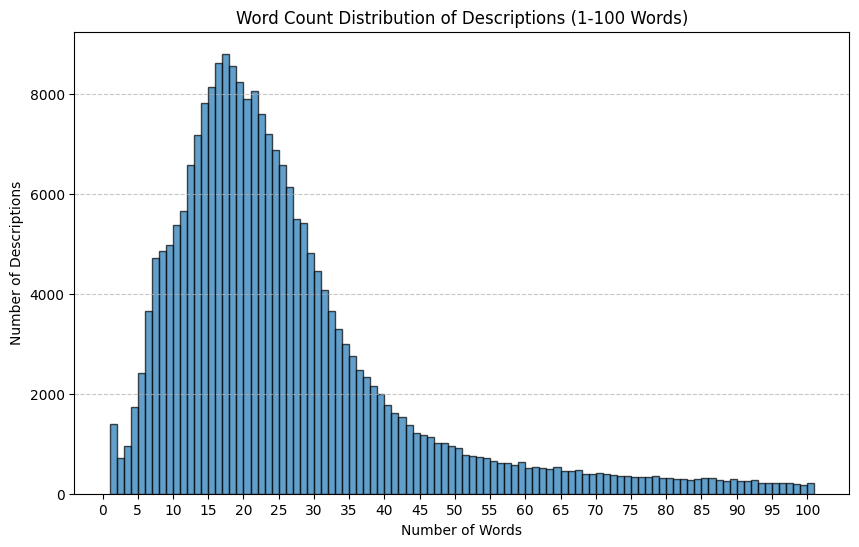

In [36]:

# Plot word count distribution
plot_word_count_distribution(data)